In [21]:
EXPORT = False

path_metadata_samples = "../../../storage/MAIN_DATA/proteomics/metadata_samples.tsv"
proteomics_full_table_path = "../../../storage/MAIN_DATA/proteomics/mouse proteinGroups.tsv"
path_gencode_id_genename = "../../../storage/external_resources/GRCm38_GENCODE/metadata_table_geneIDgeneName.tsv"

# OUTPUT
outputdir = "../results/"

# Forewords

## Goals

The aim of this notebook is :

- to preprocess the raw data table of proteomics measurements, so that we have a table that may be used in multi-omics experiments
- to set-up the analysis of differential expression of proteins

# Imports and definitions

## Imports

In [13]:
from pathlib import Path
import sys


import itertools as itt
import pandas as pd
import numpy as np

from IPython.display import display

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

mpl.rcParams.update({"figure.autolayout": True})

sns.set(style="whitegrid")

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

mpl.rc("font", size=SMALL_SIZE)
mpl.rc("axes", titlesize=SMALL_SIZE)
mpl.rc("axes", labelsize=MEDIUM_SIZE)
mpl.rc("xtick", labelsize=SMALL_SIZE)
mpl.rc("ytick", labelsize=SMALL_SIZE)
mpl.rc("legend", fontsize=SMALL_SIZE)
mpl.rc("figure", titlesize=BIGGER_SIZE)

In [ ]:
sys.path.insert(0, "../code/")

from utils import *

# Preparation

In [8]:
# Color, marker, and sample metadata for PROT.
# These should be loaded from config file(s)


map_colors = {
    "E14_Pause":"#cc5230", # Red colors,
    "E14_WT":"#00b8c1", # Cyan
}

map_marker = {1:"o", 2:"+", 3:'.'}

metadata_table_PROT = pd.DataFrame(
    [['E14_Pause1','E14_Pause',1],
    ['E14_Pause2','E14_Pause',2],
    ['E14_Pause3','E14_Pause',3],
    ['E14_WT1','E14_WT',1],
    ['E14_WT2','E14_WT',2],
    ['E14_WT3','E14_WT',3]],
    columns=['sample','group','replicate']
)

metadata_table_PROT["marker"] = metadata_table_PROT["replicate"].map(map_marker)

metadata_table_PROT["color"] = metadata_table_PROT["group"].map(map_colors)

In [9]:
display(metadata_table_PROT)


if EXPORT:
    path = pathlib.Path(path_metadata_samples)
    if not path.exists():
        metadata_table_PROT.to_csv(path, header=True, index=False, sep="\t")

,sample,group,replicate,marker,color
0,E14_Pause1,E14_Pause,1,o,#cc5230
1,E14_Pause2,E14_Pause,2,+,#cc5230
2,E14_Pause3,E14_Pause,3,.,#cc5230
3,E14_WT1,E14_WT,1,o,#00b8c1
4,E14_WT2,E14_WT,2,+,#00b8c1
5,E14_WT3,E14_WT,3,.,#00b8c1


In [19]:
# Here: convert the LFQ prefixed columns to regular columns
metadata_proteomics = pd.DataFrame(
    [['LFQ intensity E14_WT1','E14_WT1',None],
    ['LFQ intensity E14_WT2','E14_WT2',None],
    ['LFQ intensity E14_WT3','E14_WT3',None],
    ['LFQ intensity E14_Pause1','E14_Pause1',None],
    ['LFQ intensity E14_Pause2','E14_Pause2',None],
    ['LFQ intensity E14_Pause3','E14_Pause3',None]],
    columns=['LFQ_column','sample','additional_notes']
)
map_lfq_sample = metadata_proteomics.set_index("LFQ_column")["sample"].to_dict()

In [22]:
map_ENSID_geneName = pd.read_table(path_gencode_id_genename).set_index("gene_id")["gene_name"].to_dict()

display({k:v for i, (k,v) in enumerate(map_ENSID_geneName.items()) if i<5})

{'ENSMUSG00000102693.1': '4933401J01Rik',
 'ENSMUSG00000064842.1': 'Gm26206',
 'ENSMUSG00000051951.5': 'Xkr4',
 'ENSMUSG00000102851.1': 'Gm18956',
 'ENSMUSG00000103377.1': 'Gm37180'}

# Raw table analysis and preprocessing

In [37]:
outputdir = Path(outputdir)

if EXPORT:
    if not outputdir.exists():
        outputdir.mkdir()
        print("created directory `{}`".format(outputdir))

## Load

Here we load the entire table, and show both its content and the columns.

In [24]:
full_table = pd.read_csv(proteomics_full_table_path, sep="\t")
display(full_table.head(3))

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Taxonomy IDs
0,E9Q616;A0A494BBD5,E9Q616,164;6,164;6,164;6,NaN,Ahnak,tr|E9Q616|E9Q616_MOUSE AHNAK nucleoprotein (de...,2,164,...,1557,1057;1058;1238;1239;1438;1808;3876;3878;3890;4...,True;True;True;True;True;True;True;True;True;T...,1206;1207;1403;1404;1623;2022;4387;4389;4401;4...,12023;12024;12025;12026;12027;12028;12029;1203...,13751;13752;13753;13754;13755;13756;13757;1375...,13753;13762;15545;15547;17457;21133;44188;4419...,1604;1605;1606;1607;1608;1609;1610;1611;1612;1...,182;403;577;674;886;896;1021;1187;1196;1203;12...,-1;-1
1,E9QA63;E9PVY8;B1ARU4;A0A571BGC6;A0A571BF93;A0A...,E9QA63;E9PVY8;B1ARU4;A0A571BGC6;A0A571BF93;A0A...,158;158;157;145;145;145;143;49;11;10;6;5;1,158;158;157;145;145;145;143;49;11;10;6;5;1,0;0;0;0;0;0;0;0;0;0;0;0;0,NaN,Macf1,tr|E9QA63|E9QA63_MOUSE Microtubule-actin cross...,13,158,...,1422,1359;1717;1979;2061;2411;2412;3052;3169;3525;3...,True;True;True;True;True;True;True;True;True;T...,1540;1927;2219;2220;2313;2708;2709;3420;3557;3...,14646;14647;14648;14649;14650;14651;14652;1465...,16715;16716;16717;16718;16719;16720;20146;2014...,16717;20150;22951;23942;28124;28134;35214;3658...,1452;1453;1454;1455;1456;1457;1458;1459;1460;1...,646;914;932;4181;4354;4506;4555;4556;4568;4952...,-1;-1;-1;-1;-1;-1;-1;-1;-1;-1;-1;-1;-1
2,Q9JHU4;F6ZX84,Q9JHU4,152;8,152;8,152;8,Cytoplasmic dynein 1 heavy chain 1,Dync1h1,sp|Q9JHU4|DYHC1_MOUSE Cytoplasmic dynein 1 hea...,2,152,...,6072,1469;2200;2903;2959;3189;3664;4586;4810;5065;5...,True;True;True;True;True;True;True;True;True;T...,1657;1658;2468;3266;3325;3579;4152;5187;5430;5...,15638;15639;15640;15641;15642;15643;15644;1564...,17758;17759;17760;17761;17762;17763;17764;1776...,17761;25825;33992;34520;36741;42279;51693;5374...,7774;7775;7776;7777;7778;7779;7780;7781;7782;7...,189;334;400;503;548;936;984;989;1239;1344;1396...,-1;-1


## Format

In [25]:
# Filter out all columns that are not relevant.
protein_df = full_table.filter(regex="^LFQ|Majority|Gene names|Protein IDs")
display(protein_df.head(3))

,Protein IDs,Majority protein IDs,Gene names,LFQ intensity E14_Pause1,LFQ intensity E14_Pause2,LFQ intensity E14_Pause3,LFQ intensity E14_WT1,LFQ intensity E14_WT2,LFQ intensity E14_WT3
0,E9Q616;A0A494BBD5,E9Q616,Ahnak,48816000,38734000,48325000,44185000,51647000,47314000
1,E9QA63;E9PVY8;B1ARU4;A0A571BGC6;A0A571BF93;A0A...,E9QA63;E9PVY8;B1ARU4;A0A571BGC6;A0A571BF93;A0A...,Macf1,29224000,21254000,25181000,20652000,23881000,26295000
2,Q9JHU4;F6ZX84,Q9JHU4,Dync1h1,24162000,25568000,23680000,21012000,18836000,21535000


In [27]:
# Here we will drop measurements for which no gene name was found. This might require further investigation.
# We also drop measurements were there are more than one gene assigned to the measured peptite.
df_prot = protein_df.dropna(subset=["Gene names"], axis=0).loc[
    (
        lambda df: ~(df["Gene names"].replace(np.nan, ";").str.contains(";"))
        | (df["Gene names"] == "")
    ),
    :,
]


print(f"{protein_df.shape[0]:,} => {df_prot.shape[0]:,}")

6,223 => 5,938


In [28]:
# Set the gene names as index and keep only LFQ columns.
df_prot = df_prot.set_index("Gene names").filter(regex="LFQ")

# Now : transform the columns to more intelligible sample description.
df_prot.columns = [map_lfq_sample[c] for c in df_prot.columns]


# Here we also drop gene names that are associated to multiple measurementcolumnss
X_prot = df_prot.loc[~df_prot.index.duplicated(keep=False),].T.copy()

display(X_prot.head(3))

print(X_prot.index.unique())

Gene names,Ahnak,Dync1h1,Flna,Mdn1,Flnb,Myh9,Mki67,Ranbp2,Dst,Prpf8,...,Zeb1,Zfand2a,Zfand2b,Zfp566,Zfyve21,Zik1,Znf250,Znf511,Znrf2,Zscan22
E14_Pause1,48816000,24162000,79555000,33756000,39196000,28188000,12795000,35834000,3914900,84354000,...,0,0,0,0,0,0,0,0,0,0
E14_Pause2,38734000,25568000,76583000,40517000,29695000,29384000,13951000,30759000,3688900,89583000,...,0,0,0,0,0,0,0,0,0,0
E14_Pause3,48325000,23680000,87443000,37766000,34922000,33348000,13298000,36573000,3844800,79098000,...,0,0,0,0,0,0,0,0,0,0


Index(['E14_Pause1', 'E14_Pause2', 'E14_Pause3', 'E14_WT1', 'E14_WT2',
       'E14_WT3'],
      dtype='object')


In [29]:
if EXPORT:
    outputfile = outputdir / "X_prot_noScale_noDup.tsv"

    if not outputfile.exists():
        print(f"exporting to {outputfile}")
        X_prot.reset_index().to_csv(outputfile, header=True, index=False, sep="\t")

## Formatting for LFQ analyst

Here we keep the LFQ columns as is, and we build a second table that will map these to the condition name (this will be a design table).

To imitate the table that I manipulated in other experiments, I will also drop the multinames, etc.

In [30]:
sub_protein_df = protein_df.dropna(subset=["Gene names"], axis=0).loc[
    (
        lambda df: ~(df["Gene names"].replace(np.nan, ";").str.contains(";"))
        | (df["Gene names"] == "")
    ),
    :,
]

In [31]:
metadata_table_PROT

,sample,group,replicate,marker,color
0,E14_Pause1,E14_Pause,1,o,#cc5230
1,E14_Pause2,E14_Pause,2,+,#cc5230
2,E14_Pause3,E14_Pause,3,.,#cc5230
3,E14_WT1,E14_WT,1,o,#00b8c1
4,E14_WT2,E14_WT,2,+,#00b8c1
5,E14_WT3,E14_WT,3,.,#00b8c1


In [32]:
proteins_df_design = (
    metadata_table_PROT.assign(
        condition=lambda df: df["group"].str.split("_", expand=True).iloc[:, 1]
    )
    .loc[:, ["sample", "condition", "replicate"]]
    .rename(
        columns={"sample": "label", "condition": "condition", "replicate": "replicate"}
    )
    .copy()
)

display(proteins_df_design)

,label,condition,replicate
0,E14_Pause1,Pause,1
1,E14_Pause2,Pause,2
2,E14_Pause3,Pause,3
3,E14_WT1,WT,1
4,E14_WT2,WT,2
5,E14_WT3,WT,3


In [33]:
if EXPORT:
    output_fp = outputdir / "protein_DF.tsv"
    sub_protein_df.to_csv(output_fp,header=True, index=False, sep="\t")
    print(f"Wrote {output_fp}")


    output_fp = outputdir / "protein_DF_design.tsv"
    proteins_df_design.to_csv(output_fp, header=True, index=False, sep="\t")

# Explore

## Raw data visualization

In [34]:
X_prot.T.iloc[:,0]

Gene names
Ahnak      48816000
Dync1h1    24162000
Flna       79555000
Mdn1       33756000
Flnb       39196000
             ...   
Zik1              0
Znf250            0
Znf511            0
Znrf2             0
Zscan22           0
Name: E14_Pause1, Length: 5770, dtype: int64

In [35]:
def transform_sample_dist(sample_values, bins=None):
    """
    """
    if bins is None:
        return pd.Series(np.floor(np.log10(sample_values+1))).value_counts()

#pd.cut(X_prot.T.iloc[:,0], bins=np.arange(0, 18880000000, 10000), include_lowest=True).apply(lambda bin_v: bin_v.left)

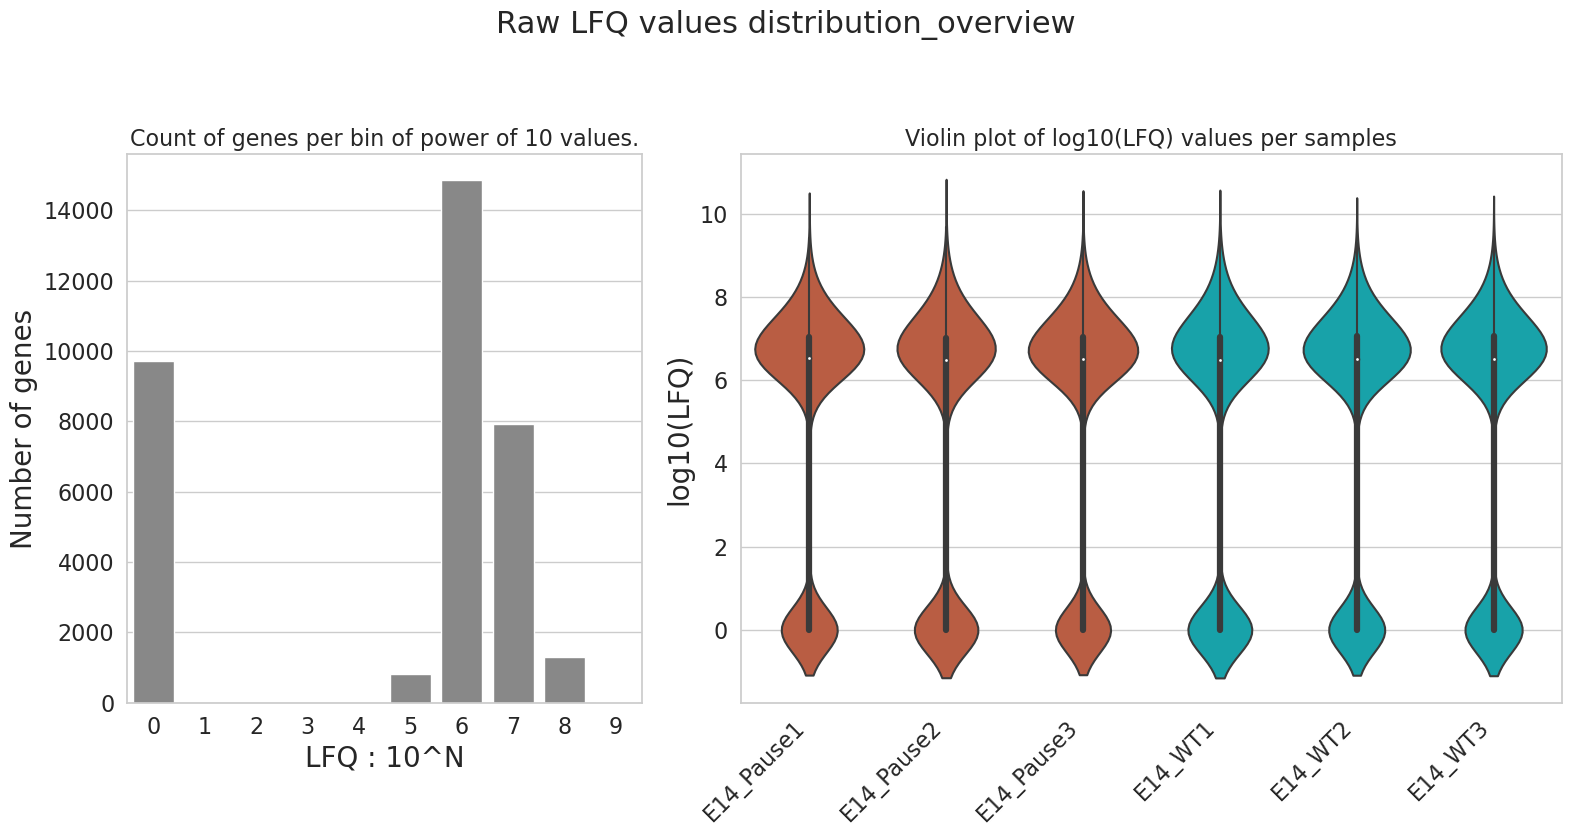

In [38]:
savefig_file = outputdir / "raw_LFQ_values_distribution_overview.svg"

tmp = pd.concat(
    [transform_sample_dist(row.values) for i, row in X_prot.iterrows()], axis=1
)

fig = plt.figure(figsize=(16, 8))
spec = gridspec.GridSpec(ncols=5, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[0, :2])

sns.barplot(
    data=tmp.reindex(list(range(0, int(max(list(tmp.index.values)) + 1))))
    .replace(np.nan, 0)
    .sum(axis=1)
    .reset_index(),
    x="index",
    y=0,
    color="#888888",
    ax=ax1,
)

ax1.set_ylabel("Number of genes")
ax1.set_xlabel("LFQ : 10^N")


ax1.set_title("Count of genes per bin of power of 10 values.")


ax2 = fig.add_subplot(spec[0, 2:])

sns.violinplot(
    data=X_prot.T.applymap(lambda v: np.log10(v + 1)).melt(),
    x="variable",
    y="value",
    palette=dict(
        list(
            itt.chain(
                *[
                    ((k + "1", v), (k + "2", v), (k + "3", v))
                    for k, v in map_colors.items()
                ]
            )
        )
    ),
    ax=ax2,
)

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

ax2.set_xlabel("")
ax2.set_ylabel("log10(LFQ)")


ax2.set_title("Violin plot of log10(LFQ) values per samples")


plt.suptitle("Raw LFQ values distribution_overview", y=1.05)

if EXPORT:
    plt.savefig(savefig_file)

plt.show()

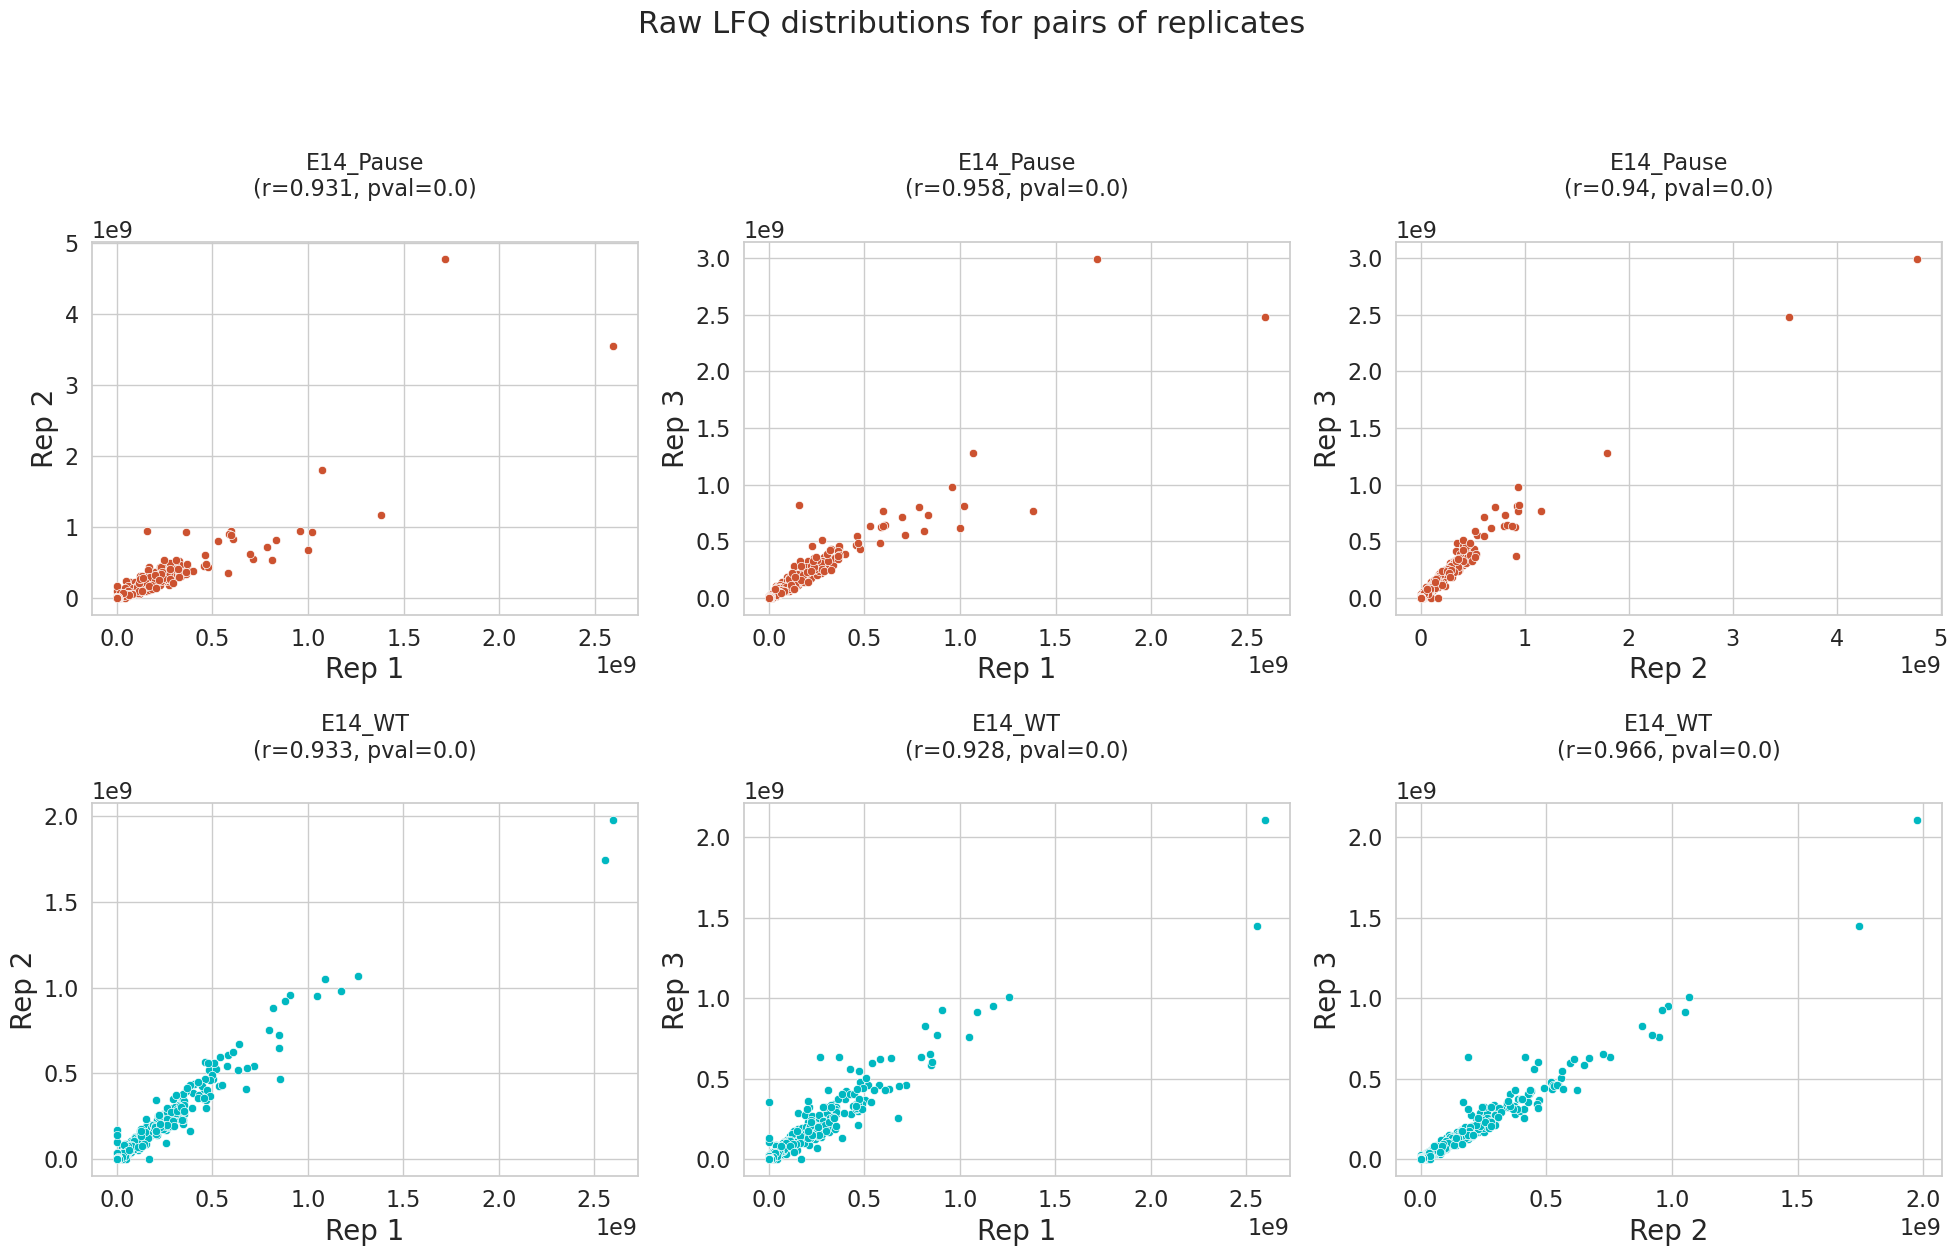

In [42]:
if EXPORT:
    savefig_file = outputdir + "/raw_LFQ_values_distribution_pairs-replicates.svg"
else:
    savefig_file = None

plot_pairs_samples(
    X_prot.T,
    metadata_table_PROT,
    main_title="Raw LFQ distributions for pairs of replicates",
    map_colors=map_colors,
    savefig_file=savefig_file,
)

# Transformation and export new tables

We first transform to logN values, and subtract the median of each sample.

## Transform counts

### Median scaled

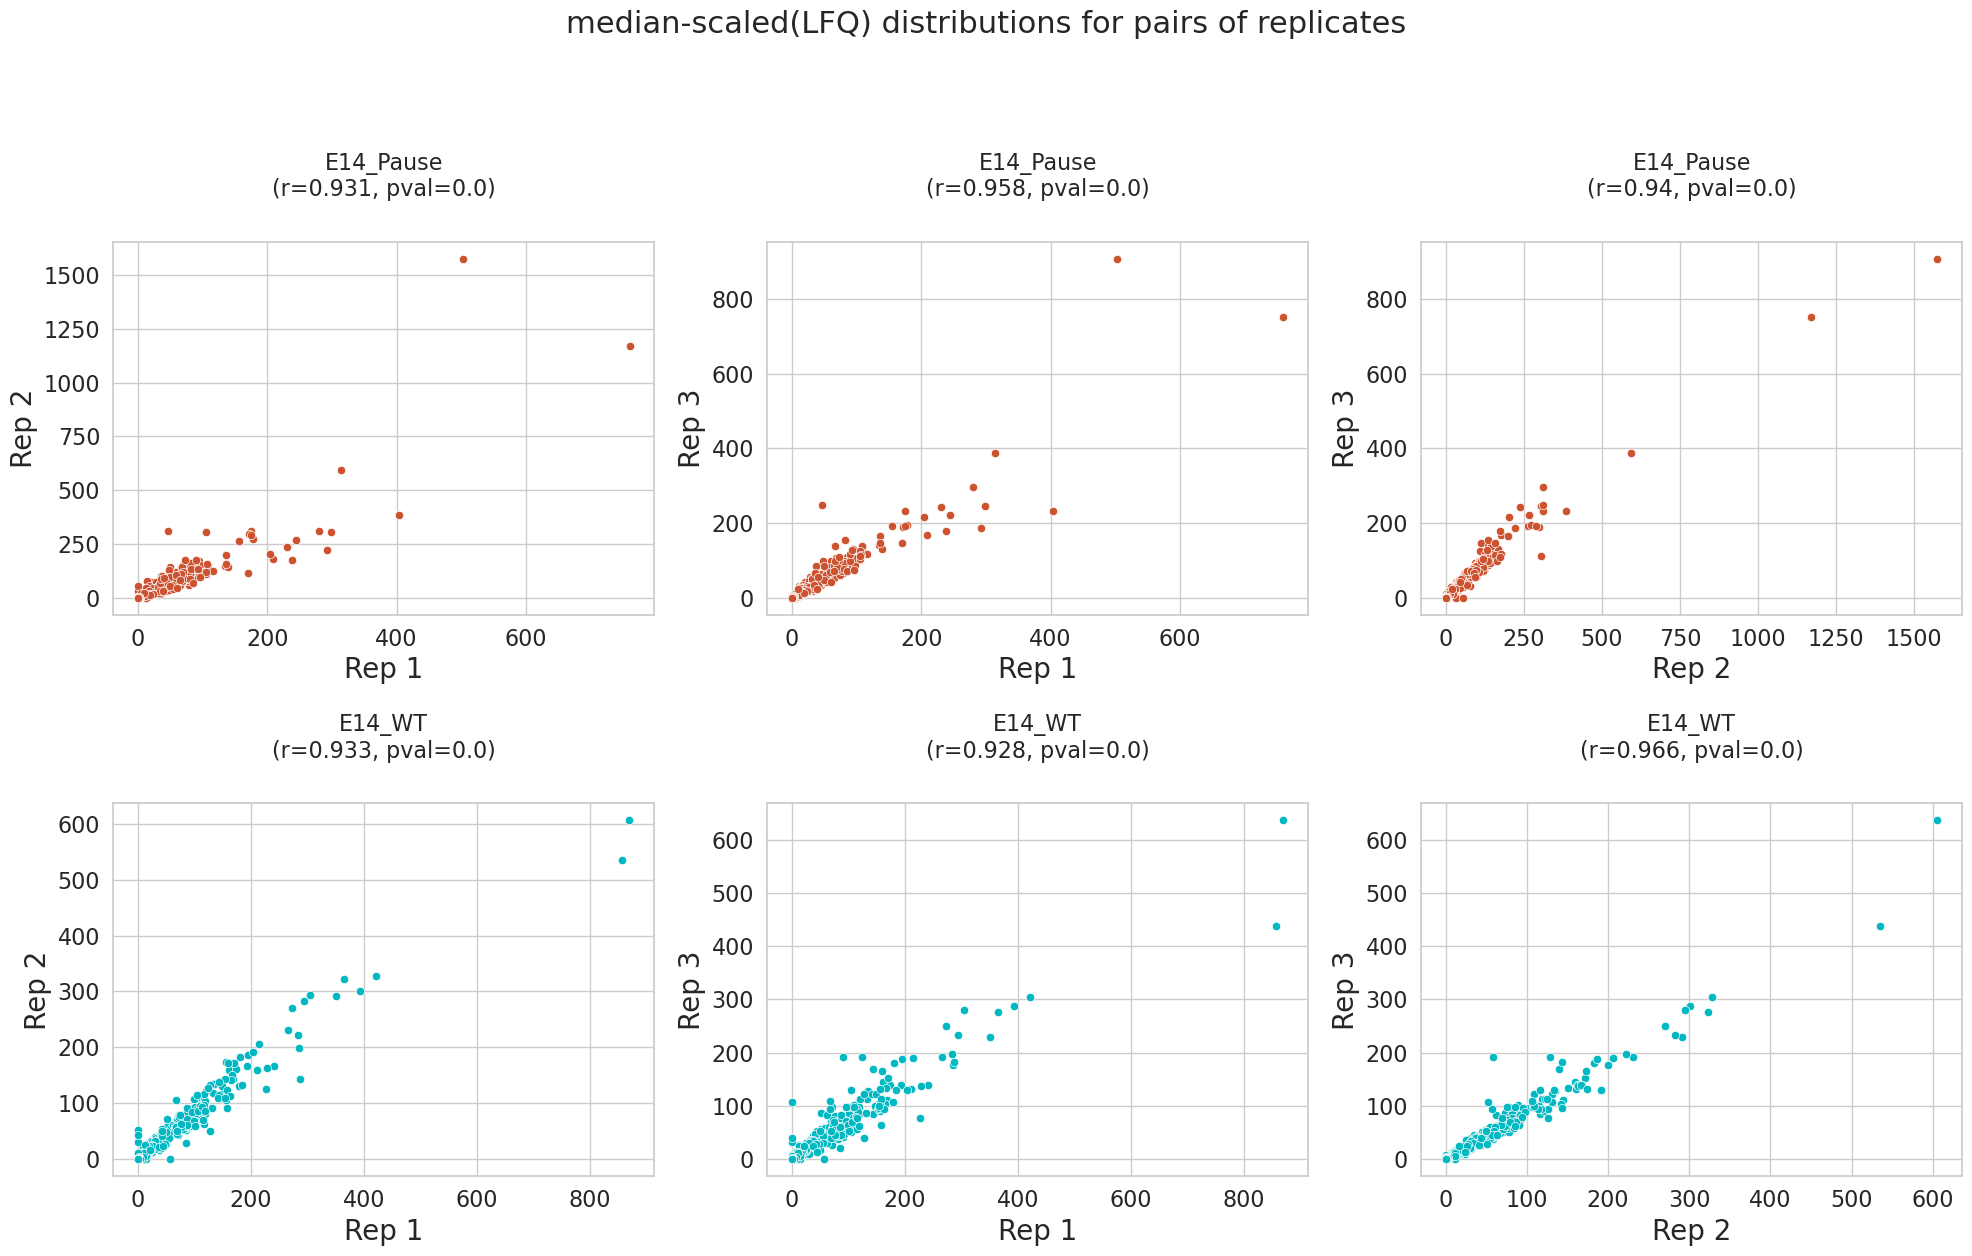

In [44]:
X_prot_medScale = X_prot.div(X_prot.median(axis=1),axis=0).T

if EXPORT:
    savefig_file = outputdir / "medScaled-LFQ_values_distribution_pairs-replicates.svg"
else:
    savefig_file = None

plot_pairs_samples(
    X_prot_medScale,
    metadata_table_PROT,
    main_title="median-scaled(LFQ) distributions for pairs of replicates",
    map_colors=map_colors,
    savefig_file=savefig_file,
)

if EXPORT:
    X_prot_medScale.reset_index().to_csv(
        outputdir / "X_prot_medScale_noDup.tsv",
        header=True, index=False, sep="\t")